In [1]:
import re
import os
import gc
import datetime

import pandas as pd
import numpy as np

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import gensim
from gensim.models import word2vec
from gensim.models import KeyedVectors #  implements word vectors
from gensim.test.utils import datapath, get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec

from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

import matplotlib.cm as cm

import spacy

from tqdm.auto import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/paramiko/transport.py:237: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
df = pd.read_csv('../data/Module_5_Lecture_1_Class_amazon_product_reviews.csv', index_col='Id')

# Quick data pre-processing

df = df.loc[df['Score']!=3]

df['sentiment'] = [1 if score in [4, 5] else 0 for score in df['Score']]

df = df.drop_duplicates().reset_index(drop=True)

df = df.drop_duplicates(subset={"UserId", "Time","Text"})

# Final size 

df.shape

(364133, 10)

In [3]:
# Contractions. Source http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [4]:
# Stop-words
stop_words = set(stopwords.words('english')).union({'also', 'would', 'much', 'many'})

negations = {
    'aren',
    "aren't",
    'couldn',
    "couldn't",
    'didn',
    "didn't",
    'doesn',
    "doesn't",
    'don',
    "don't",
    'hadn',
    "hadn't",
    'hasn',
    "hasn't",
    'haven',
    "haven't",
    'isn',
    "isn't",
    'mightn',
    "mightn't",
    'mustn',
    "mustn't",
    'needn',
    "needn't",
    'no',
    'nor',
    'not',
    'shan',
    "shan't",
    'shouldn',
    "shouldn't",
    'wasn',
    "wasn't",
    'weren',
    "weren't",
    'won',
    "won't",
    'wouldn',
    "wouldn't"
}

stop_words = stop_words.difference(negations)

In [5]:
nlp = spacy.load("en_core_web_sm", disable = ['parser','ner'])

def normalize_text(raw_review):
    
    # Remove html tags
    text = re.sub("<[^>]*>", " ", raw_review) # match <> and everything in between. [^>] - match everything except >
    
    # Remove emails
    text = re.sub("\S*@\S*[\s]+", " ", text) # match non-whitespace characters, @ and a whitespaces in the end
    
    # remove links
    text = re.sub("https?:\/\/.*?[\s]+", " ", text) # match http, s - zero or once, //, 
                                                    # any char 0-unlimited, whitespaces in the end
        
     # Convert to lower case, split into individual words
    text = text.lower().split()
    
    # Replace contractions with their full versions
    text = [contractions.get(word) if word in contractions else word 
            for word in text]
   
    # Re-splitting for the correct stop-words extraction
    text = " ".join(text).split()    
    
    # Remove stop words
    text = [word for word in text if not word in stop_words]

    text = " ".join(text)
    
    # Remove non-letters        
    text = re.sub("[^a-zA-Z' ]", "", text) # match everything except letters and '


    # Stem words. Need to define porter stemmer above
    # text = [stemmer.stem(word) for word in text.split()]

    # Lemmatize words. Need to define lemmatizer above
    doc = nlp(text)
    text = " ".join([token.lemma_ for token in doc if len(token.lemma_) > 1 ])
    
    # Remove excesive whitespaces
    text = re.sub("[\s]+", " ", text)    
    
    # Join the words back into one string separated by space, and return the result.
    return(text)

In [6]:
# Slicing dataset for demonstrative purposes

df = df.groupby('sentiment').sample(2500, random_state=42).reset_index(drop=True)

# Note: without resetting an index we slice over the original Id`s
df.shape

(5000, 10)

In [7]:
df['text_normalized'] = df['Text'].progress_apply(normalize_text)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [8]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for sentence in data:
        word_list = sentence.split(" ")
        corpus.append(word_list)    
           
    return corpus

In [9]:
corpus = build_corpus(df['text_normalized'])
corpus[0]

['suppose',
 'people',
 'might',
 'rate',
 'product',
 'high',
 'great',
 'substitute',
 'bisquik',
 'however',
 'not',
 'like',
 'everything',
 'make',
 'tasted',
 'like',
 'bisquik']

In [10]:
# vector_size - Dimensionality of the word vectors
# window - Maximum distance between the current and predicted word within a sentence
# min_count - Ignores all words with total frequency lower than this

model_emb_from_scratch = word2vec.Word2Vec(corpus, vector_size=100, window=5, min_count=50, workers=4)

# saving vectors
model_emb_from_scratch.wv.save_word2vec_format('../saved_models/model_emb_from_scratch.bin', binary=True)

In [11]:
class WordEmbedding: 

    def __init__(self):
        self.model = {}
        
    def convert(self, source, ipnut_file_path, output_file_path):
        '''
        Converts word embeddings from GloVe format to Word2Vec format
        '''
        if source == 'glove':
            glove2word2vec(ipnut_file_path, output_file_path)
        elif source in ['word2vec', 'fasttext', 'from_scratch']:
            pass
        else:
            raise ValueError('Possible value of source are glove, word2vec, fasttext, or from_scratch')
        
    def load(self, source, file_path):
        '''
        Loads a specified word embedding model from a file
        '''
        print(datetime.datetime.now(), 'start: loading', source)
        if source in ['glove', 'fasttext']:
            self.model[source] = gensim.models.KeyedVectors.load_word2vec_format(file_path)
        elif source in ['word2vec', 'from_scratch']:
            self.model[source] = gensim.models.KeyedVectors.load_word2vec_format(file_path, binary=True)
        else:
            raise ValueError('Possible value of source are glove, word2vec, fasttext, or from_scratch')
            
        print(datetime.datetime.now(), 'end: loading', source)
            
        return self
    
    def get_model(self, source):
        '''
        Retrieves the loaded word embedding model
        '''
        if source not in ['glove', 'word2vec', 'fasttext', 'from_scratch']:
            raise ValueError('Possible value of source are glove, word2vec, fasttext, or from_scratch')
            
        return self.model[source]
    
    def get_words(self, source, size=None):
        '''
        Retrieves a list of words from the model
        '''
        if source not in ['glove', 'word2vec', 'fasttext', 'from_scratch']:
            raise ValueError('Possible value of source are glove, word2vec, fasttext, or from_scratch')

        if size is None:
            return [w for w in self.get_model(source=source).key_to_index]
        else:
            results = []
            for i, word in enumerate(self.get_model(source=source).key_to_index):
                if i >= size:
                    break
                results.append(word)
            return results
        
        return Exception('Unexpected flow')
    
    def get_dimension(self, source):
        '''
        Retrieves the dimension of word vectors in the model
        '''
        if source not in ['glove', 'word2vec', 'fasttext', 'from_scratch']:
            raise ValueError('Possible value of source are glove, word2vec, fasttext, or from_scratch')
        
        return self.get_model(source=source).vectors[0].shape[0]
    
    def get_vectors(self, source, words=None):
        '''
        Retrieves vectors for specified words or for all words in the model
        '''
        if source not in ['glove', 'word2vec', 'fasttext', 'from_scratch']:
            raise ValueError('Possible value of source are glove, word2vec, fasttext, or from_scratch')
        
        if words is None:
            words = self.get_words(source=source)
            
        embedding = np.empty((len(words), self.get_dimension(source=source)), dtype=np.float32)
        for i, word in enumerate(words):
            embedding[i] = self.get_vector(source=source, word=word)
                
        return embedding
            
    def get_vector(self, source, word):
        '''
        Retrieves the vector representation of a single word
        '''
        if source not in ['glove', 'word2vec', 'fasttext', 'from_scratch']:
            raise ValueError('Possible value of source are glove, word2vec, fasttext, or from_scratch')
            
        if source not in self.model:
            raise ValueError('Did not load %s model yet' % source)
        
        try:
            return self.model[source][word]
        except KeyError as e:
            dims = self.model[source][0].shape
            vect = np.empty(dims)
            vect[:] = np.nan
            return vect
            
    def get_synonym(self, source, word, topn=5):
        '''
        Retrieves synonyms for a given word
        '''
        if source not in ['glove', 'word2vec', 'fasttext', 'from_scratch']:
            raise ValueError('Possible value of source are glove, word2vec, fasttext, or from_scratch')
            
        if source not in self.model:
            raise ValueError('Did not load %s model yet' % source)
        
        try:
            return self.model[source].most_similar(positive=word, topn=topn)
        except KeyError as e:
            raise
    
    def get_distance_between_two_words(self, source, word1, word2):
        '''
        Calculates cosine similarity between two words in the model
        '''
        if source not in ['glove', 'word2vec', 'fasttext', 'from_scratch']:
            raise ValueError('Possible value of source are glove, word2vec, fasttext, or from_scratch')
            
        if source not in self.model:
            raise ValueError('Did not load %s model yet' % source)
        
        try:
            return self.model[source].similarity(word1, word2)
        except KeyError as e:
            raise

In [12]:
word2vec_file_path = '../pretrained_models/GoogleNews-vectors-negative300.bin'

fasttext_file_path = '../pretrained_models/wiki-news-300d-1M.vec'

from_scratch_file_path = '../saved_models/model_emb_from_scratch.bin'

# adding absolute path for correct gensim work
downloaded_glove_file_path = '../pretrained_models' + '/glove.6B.50d.txt'
glove_file_path = '../pretrained_models' + '/glove.6B.50d.vec'

____

In [14]:
gc.collect()

861

In [15]:
word_embedding = WordEmbedding()

In [16]:
# We may need to convert text file (downloaed from GloVe website) to vector format
word_embedding.convert(source='glove', ipnut_file_path=downloaded_glove_file_path, output_file_path=glove_file_path)

/tmp/ipykernel_25055/2216606991.py:11: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(ipnut_file_path, output_file_path)


In [17]:
%%time
# word_embedding.load(source='word2vec', file_path=word2vec_file_path)
word_embedding.load(source='glove', file_path=glove_file_path)
# word_embedding.load(source='fasttext', file_path=fasttext_file_path)
word_embedding.load(source='from_scratch', file_path=from_scratch_file_path)

2024-08-15 15:11:10.627898 start: loading glove
2024-08-15 15:11:18.950362 end: loading glove
2024-08-15 15:11:18.950463 start: loading from_scratch
2024-08-15 15:11:18.954221 end: loading from_scratch
CPU times: user 8.26 s, sys: 67.4 ms, total: 8.33 s
Wall time: 8.33 s


In [18]:
# Get vectors

for source in ['glove', 'from_scratch']: # 'word2vec', 'fasttext',
    print('Source: %s' % (source))
    print(word_embedding.get_vector(source=source, word='cat'))
    print(len(word_embedding.get_vector(source=source, word='cat')))

Source: glove
[ 0.45281  -0.50108  -0.53714  -0.015697  0.22191   0.54602  -0.67301
 -0.6891    0.63493  -0.19726   0.33685   0.7735    0.90094   0.38488
  0.38367   0.2657   -0.08057   0.61089  -1.2894   -0.22313  -0.61578
  0.21697   0.35614   0.44499   0.60885  -1.1633   -1.1579    0.36118
  0.10466  -0.78325   1.4352    0.18629  -0.26112   0.83275  -0.23123
  0.32481   0.14485  -0.44552   0.33497  -0.95946  -0.097479  0.48138
 -0.43352   0.69455   0.91043  -0.28173   0.41637  -1.2609    0.71278
  0.23782 ]
50
Source: from_scratch
[ 0.08007126  0.07006534  0.07490037  0.6558005   0.12758356  0.17691657
  0.1814931   0.3168262  -0.9292222  -0.68286186  0.492274   -0.36573234
  0.06020065  0.3057309   0.08713005 -0.44987577  0.19482358 -0.21219467
 -0.541946   -0.7369006   0.16910695  0.10446227 -0.47370052 -0.09644046
 -0.42613024 -0.06913826  0.2667418   0.2716068   0.03622798  0.04990835
  0.21567716  0.37741956 -0.15564662 -0.15684737 -0.46524787  0.41307744
 -0.5987259  -1.257316

In [19]:
# Get Most Similar Words

for source in ['glove', 'from_scratch']: # 'word2vec', 'fasttext',
    print('Source: %s' % (source))
    print(word_embedding.get_synonym(source=source, word='cat', topn=5))

Source: glove
[('dog', 0.9218006134033203), ('rabbit', 0.8487821221351624), ('monkey', 0.8041081428527832), ('rat', 0.7891963124275208), ('cats', 0.7865270376205444)]
Source: from_scratch
[('dog', 0.9890621900558472), ('treat', 0.9784572720527649), ('feed', 0.9683513641357422), ('food', 0.9581679105758667), ('they', 0.9205523729324341)]


In [20]:
# Get Distance

w1 = 'king'
w2 = 'queen'

for source in ['glove']: # 'word2vec', 'fasttext'
    print('Source: %s' % (source))
    print(word_embedding.get_distance_between_two_words(source=source,word1=w1, word2=w2))

Source: glove
0.78390425


In [21]:
del word_embedding

In [22]:
gc.collect()

0

___

**Important**

At this point, your machine may run out of memory. In the next step, the kernel may die.
It's highly recommended to restart the kernel and run everything till the following part:

```
word2vec_file_path = '../pretrained_models/GoogleNews-vectors-negative300.bin'

fasttext_file_path = '../pretrained_models/wiki-news-300d-1M.vec'

from_scratch_file_path = '../saved_models/model_emb_from_scratch.bin'

# adding absolute path for correct gensim work
downloaded_glove_file_path = '../pretrained_models' + '/glove.6B.50d.txt'
glove_file_path = '../pretrained_models' + '/glove.6B.50d.vec'word2vec_file_path = '../pretrained_models/GoogleNews-vectors-negative300.bin'

fasttext_file_path = '../pretrained_models/wiki-news-300d-1M.vec'

from_scratch_file_path = '../saved_models/model_emb_from_scratch.bin'

# adding absolute path for correct gensim work
downloaded_glove_file_path = '../pretrained_models' + '/glove.6B.50d.txt'
glove_file_path = '../pretrained_models' + '/glove.6B.50d.vec'
```

Skip the code after (this code is separated with the markdown) and proceed running the code starting the next cell.

In [13]:
model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_file_path, binary=True)

In [14]:
keys = ['Paris', 'Python', 'Sunday', 'Shakespeare', 'Twitter', 'bachelor', 'delivery', 'election', 'expensive',
        'experience', 'financial', 'food', 'iOS', 'release']

embedding_clusters = []
word_clusters = []

for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [15]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

tsne_model_en_2d = TSNE(
    perplexity=10, # The perplexity is related to the number of nearest neighbors 
                   # that is used in other manifold learning algorithms
    n_components=2, # Dimension of the embedded space
    init='pca', # PCA initialization cannot be used with precomputed distances and is 
                # usually more globally stable than random initialization
    n_iter=3500, # Maximum number of iterations for the optimization. Should be at least 250
    random_state=42
)

embeddings_en_2d = np.array(
    tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

embeddings_en_2d.shape

(14, 10, 2)

In [16]:
embedding_clusters.shape

(14, 10, 300)

In [17]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, alpha, filename=None):
    
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, color=color, alpha=alpha, label=label, )
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

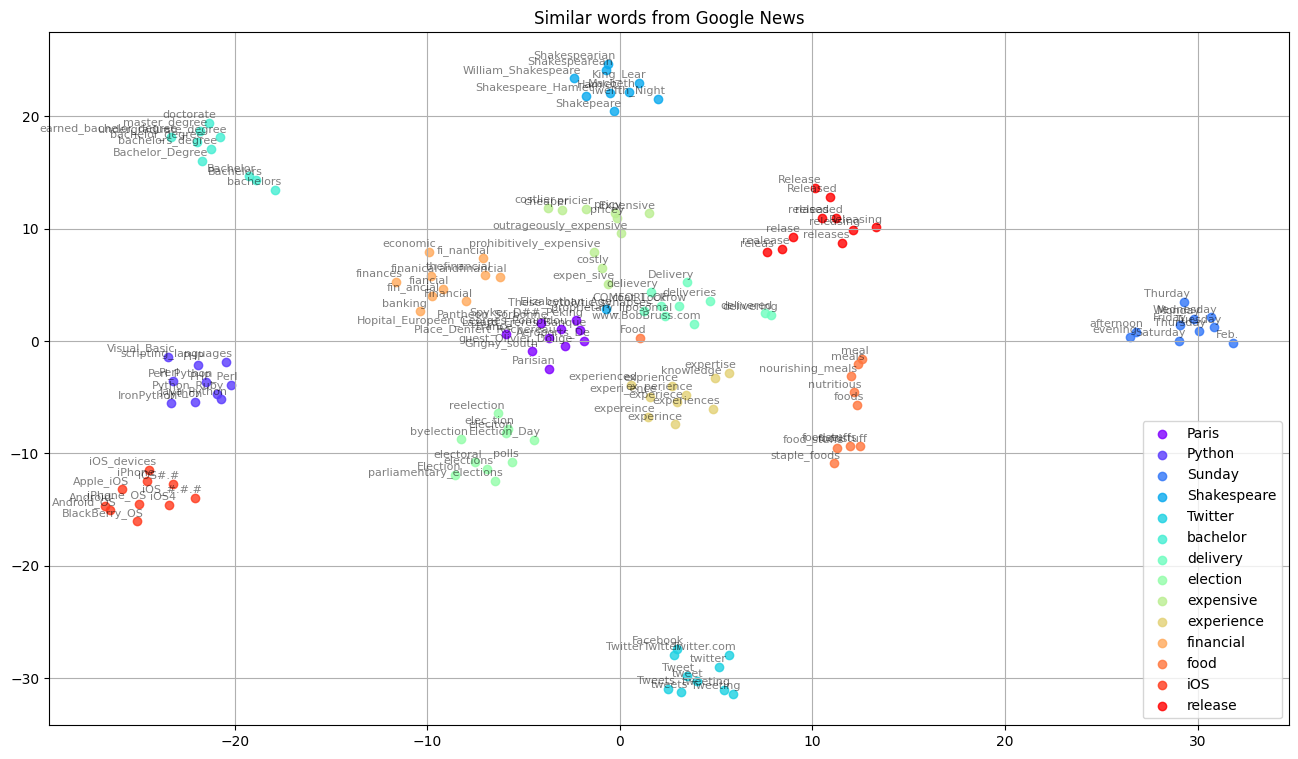

In [18]:
tsne_plot_similar_words('Similar words from Google News', keys, embeddings_en_2d, word_clusters, 0.8)

In [19]:
del model

In [20]:
def tok2vec(tokens, source:str, avg:str):
    """
    Given a list of tokens, return their vector representation.
    Args:
        tokens: List(str) tokenized input
        source: embedding algorithm to use with the WordEmbedding object
        avg: vectors averaging method - `sum` or `mean` of all vectors
    """
    vects = word_embedding.get_vectors(source=source, words=tokens)

    if avg == 'mean':
        return np.nanmean(vects, axis=0)
    elif avg == 'sum':
        return np.nansum(vects, axis=0)
    else:
        raise ValueError('Select correct averaging method: sum or mean')

In [21]:
word_embedding = WordEmbedding()

In [32]:
gc.collect()

0

In [24]:
source = 'word2vec'

word_embedding.load(source=source, file_path=word2vec_file_path)

2024-08-15 15:20:47.463859 start: loading word2vec
2024-08-15 15:21:01.764510 end: loading word2vec


In [25]:
train_idxs = df.sample(frac=0.8, random_state=42).index
test_idxs = [idx for idx in df.index if idx not in train_idxs]

X_train = df.loc[train_idxs, 'text_normalized'].apply(
    word_tokenize).apply(lambda x: tok2vec(x, source, 'mean')).to_numpy()

X_test = df.loc[test_idxs, 'text_normalized'].apply(
    word_tokenize).apply(lambda x: tok2vec(x, source, 'mean')).to_numpy()

X_train = np.stack(X_train, axis=0)
X_test = np.stack(X_test, axis=0)

y_train = df.loc[train_idxs, 'sentiment']
y_test = df.loc[test_idxs, 'sentiment']

In [26]:
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [27]:
predictions = model.predict(X_test)

print('AUC: ', roc_auc_score(y_test, predictions))

AUC:  0.8071177944862156


In [28]:
text_tokenized = df['text_normalized'].apply(word_tokenize).to_list()

In [29]:
def tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

In [30]:
text_tokenized_tagget = list(tagged_document(text_tokenized))

In [31]:
text_tokenized_tagget[3]

TaggedDocument(words=['try', 'differant', 'brand', 'juice', 'imply', 'get', 'relief', 'arthritis', 'pain', 'save', 'money', 'buy', 'tylenol', 'brand', 'good', 'bland', 'taste', 'nothing', 'pain'], tags=[3])

In [33]:
model_Doc2Vec = gensim.models.doc2vec.Doc2Vec(vector_size=300, min_count=5, epochs=200)

model_Doc2Vec.build_vocab(text_tokenized_tagget)

model_Doc2Vec.train(text_tokenized_tagget, total_examples=model_Doc2Vec.corpus_count, epochs=model_Doc2Vec.epochs)

In [34]:
model_Doc2Vec.infer_vector(text_tokenized[0]).shape

(300,)

In [35]:
X = [model_Doc2Vec.infer_vector(x) for x in text_tokenized]

In [36]:
X_train = [X[idx] for idx in train_idxs]
X_test = [X[idx] for idx in test_idxs]

X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

In [37]:
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

print('AUC: ', roc_auc_score(y_test, predictions))

AUC:  0.8170426065162907
